[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/multi-modal/clip-search/clip-text-image-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/multi-modal/clip-search/clip-text-image-search.ipynb)

# Text-to-Image and Image-to-image search Using CLIP

@Author: Zoumana KEITA
https://zoumanakeita.medium.com/

In [1]:
import torch

print(torch.__version__)

2.2.0+cu118


# Import libraries

In [2]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel

c:\Users\phuon\anaconda3\envs\django_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Exploration

## Load Data

In [3]:
image_data_df = pd.read_csv('../dataset/results.csv').dropna(axis=1)
image_data_df = image_data_df.applymap(lambda x: x.replace('"', '') if isinstance(x, str) else x)
image_data_df = image_data_df.iloc[:, 0].str.split('|', expand=True)
image_data_df.columns = ['image_name', 'comment_number', 'comment']
image_data_df ['comment'] = image_data_df ['comment'].apply(lambda x: '' if pd.isna(x) else x)
image_data_df.info()

C:\Users\phuon\AppData\Local\Temp\ipykernel_16780\2326882435.py:1: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  image_data_df = pd.read_csv('../dataset/results.csv').dropna(axis=1)
C:\Users\phuon\AppData\Local\Temp\ipykernel_16780\2326882435.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  image_data_df = image_data_df.applymap(lambda x: x.replace('"', '') if isinstance(x, str) else x)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   comment_number  158915 non-null  object
 2   comment         158915 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [4]:
image_data_df.head()

image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1                                         Two young   
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

In [5]:
image_data_df['comment'] = image_data_df.groupby('image_name')['comment'].transform(lambda x: ' '.join(x))
image_data_df = image_data_df.drop_duplicates(subset=['image_name'])
image_data_df = image_data_df.drop(['comment_number'], axis=1)
image_data_df = image_data_df.reset_index(drop=True)
image_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31783 entries, 0 to 31782
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  31783 non-null  object
 1   comment     31783 non-null  object
dtypes: object(2)
memory usage: 496.7+ KB


In [6]:
image_data_df.head()

image_name                                            comment
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1    10002456.jpg   Several men in hard hats are operating a gian...
2  1000268201.jpg   A child in a pink dress is climbing up a set ...
3  1000344755.jpg   Someone in a blue shirt and hat is standing o...
4  1000366164.jpg   Two men   Two guy cooking and joking around w...

In [7]:
image_data_df.count()

image_name    31783
comment       31783
dtype: int64

## Get feature extraction

In [8]:
def get_image(image_path):
    image = Image.open(f"../dataset/flickr30k_images/{image_path}").convert("RGB")
    return image

def get_image_caption(image_ID):
    return image_data_df.loc[image_ID][' comment']

In [9]:
image_data_df["image"] = image_data_df["image_name"].apply(get_image)

In [10]:
image_data_df.head(5)

image_name                                            comment  \
0  1000092795.jpg   Two young guys with shaggy hair look at their...   
1    10002456.jpg   Several men in hard hats are operating a gian...   
2  1000268201.jpg   A child in a pink dress is climbing up a set ...   
3  1000344755.jpg   Someone in a blue shirt and hat is standing o...   
4  1000366164.jpg   Two men   Two guy cooking and joking around w...   

                                               image  
0  <PIL.Image.Image image mode=RGB size=333x500 a...  
1  <PIL.Image.Image image mode=RGB size=500x374 a...  
2  <PIL.Image.Image image mode=RGB size=375x500 a...  
3  <PIL.Image.Image image mode=RGB size=500x333 a...  
4  <PIL.Image.Image image mode=RGB size=500x375 a...

In [11]:
def get_model_info(model_ID, device):
  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)
  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)
  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)
  # Return model, processor & tokenizer
  return model, processor, tokenizer

Danh sách các model có thể pretrained của CLIP:
* "openai/clip-vit-large-patch14": https://huggingface.co/openai/clip-vit-large-patch14
* "openai/clip-vit-base-patch16": https://huggingface.co/openai/clip-vit-base-patch16
* "openai/clip-vit-base-patch32": https://huggingface.co/openai/clip-vit-base-patch32

In [12]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"
model, processor, tokenizer = get_model_info(model_ID, device)

# Create Embeddings: Text and Image Embeddings

## Text Embeddings

In [71]:
def get_single_text_embedding(text):
  # print(text)
  inputs = tokenizer(text, return_tensors = "pt", truncation=True).to(device)
  text_embeddings = model.get_text_features(**inputs)
  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()
  return embedding_as_np

In [72]:
def get_all_text_embedding(df, img_column):
    df["text_embeddings"] = df[str(img_column)].apply(lambda x: get_single_text_embedding(x))
    return df

In [20]:
image_data_df = get_all_text_embedding(image_data_df, "comment")
image_data_df.head(5)

image_name                                            comment  \
0  1000092795.jpg   Two young guys with shaggy hair look at their...   
1    10002456.jpg   Several men in hard hats are operating a gian...   
2  1000268201.jpg   A child in a pink dress is climbing up a set ...   
3  1000344755.jpg   Someone in a blue shirt and hat is standing o...   
4  1000366164.jpg   Two men   Two guy cooking and joking around w...   

                                               image  \
0  <PIL.Image.Image image mode=RGB size=333x500 a...   
1  <PIL.Image.Image image mode=RGB size=500x374 a...   
2  <PIL.Image.Image image mode=RGB size=375x500 a...   
3  <PIL.Image.Image image mode=RGB size=500x333 a...   
4  <PIL.Image.Image image mode=RGB size=500x375 a...   

                                      img_embeddings  \
0  [[0.21002507, 0.57016265, -0.47346586, -0.5421...   
1  [[-0.60949385, -0.246148, -0.082945876, 0.2532...   
2  [[0.073100016, -0.5649446, -0.13721694, 0.5737...   
3  [[-0.08842755, 0.10557106, -0.17388728, 0.4667...   
4  [[-0.529148, 0.25061727, -0.03592848, 0.121195...   

                                     text_embeddings  
0  [[0.21002507, 0.57016265, -0.47346586, -0.5421...  
1  [[-0.60949385, -0.246148, -0.082945876, 0.2532...  
2  [[0.073100016, -0.5649446, -0.13721694, 0.5737...  
3  [[-0.08842755, 0.10557106, -0.17388728, 0.4667...  
4  [[-0.529148, 0.25061727, -0.03592848, 0.121195...

## Image Embeddings

In [21]:
def get_single_image_embedding(my_image):
  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)
  embedding = model.get_image_features(image)
  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()
  return embedding_as_np

### Get the embedding of all the images

In [22]:
def get_all_images_embedding(df, img_column):
  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
  return df

In [23]:
image_data_df = get_all_images_embedding(image_data_df, "image")

In [24]:
image_data_df.head()

image_name                                            comment  \
0  1000092795.jpg   Two young guys with shaggy hair look at their...   
1    10002456.jpg   Several men in hard hats are operating a gian...   
2  1000268201.jpg   A child in a pink dress is climbing up a set ...   
3  1000344755.jpg   Someone in a blue shirt and hat is standing o...   
4  1000366164.jpg   Two men   Two guy cooking and joking around w...   

                                               image  \
0  <PIL.Image.Image image mode=RGB size=333x500 a...   
1  <PIL.Image.Image image mode=RGB size=500x374 a...   
2  <PIL.Image.Image image mode=RGB size=375x500 a...   
3  <PIL.Image.Image image mode=RGB size=500x333 a...   
4  <PIL.Image.Image image mode=RGB size=500x375 a...   

                                      img_embeddings  \
0  [[1.4344304, 1.193391, 0.21873435, 0.24441841,...   
1  [[0.14477712, 0.10045184, -0.4702826, 0.991804...   
2  [[0.70503384, -0.8119767, -0.5883298, 0.852969...   
3  [[0.5549269, 0.3604017, -0.13216421, 1.5481927...   
4  [[0.7432167, 0.074646145, 0.0016327798, 0.7597...   

                                     text_embeddings  
0  [[0.21002507, 0.57016265, -0.47346586, -0.5421...  
1  [[-0.60949385, -0.246148, -0.082945876, 0.2532...  
2  [[0.073100016, -0.5649446, -0.13721694, 0.5737...  
3  [[-0.08842755, 0.10557106, -0.17388728, 0.4667...  
4  [[-0.529148, 0.25061727, -0.03592848, 0.121195...

In [25]:
image_data_df.text_embeddings.values[0].shape

(1, 768)

In [26]:
image_data_df.img_embeddings.values[0].shape

(1, 768)

# Perform Similarity Search: Cosine

## 1. Cosine Similarity Search

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
def get_top_N_images(query, data, top_K=10, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else:
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["image_name", "comment", "image", "cos_sim"]

    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    Sort Cosine Similarity Column in Descending Order
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False).drop_duplicates(subset='image_name')[1:top_K+1]

    return most_similar_articles[revevant_cols].reset_index()

In [40]:
def plot_images_by_side(top_images):
    index_values = list(top_images.index.values)
    list_images = [top_images.iloc[idx].image for idx in index_values]
    similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

    n_col = 2
    n_row = int(top_images.shape[0]/n_col)
    print("🌷:",n_row)

    _, axs = plt.subplots(n_row, n_col, figsize=(20, 20))
    axs = axs.flatten()
    for img, ax, sim_score in zip(list_images, axs, similarity_score):
        ax.imshow(img)
        sim_score = 100*float("{:.2f}".format(sim_score))
        ax.title.set_text(f"Similarity: {sim_score}%")
    plt.show()

In [29]:
image_data_df.columns

Index(['image_name', 'comment', 'image', 'img_embeddings', 'text_embeddings'], dtype='object')

### a. Text to image search

In [47]:
# query_caption = image_data_df.iloc[10].caption
query_caption = "A dolphin is under the sea"


top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: A dolphin is under the sea


index      image_name                                            comment  \
0  14290  3454051143.jpg   A topless man in a swimsuit sits at the botto...   
1   1791  1496935683.jpg   Two scuba divers are diving underwater and me...   
2   8261  2735822661.jpg   A blond girl is sitting drinking a soda and l...   
3   3858  2178306830.jpg   The scuba diver floats underwater looking at ...   
4  28850  6556868159.jpg   A girl in a bikini swims underwater in clear ...   
5  31458   866841633.jpg   A person paddles a boat while another has fal...   
6  24880  4899253248.jpg   A girl wearing pink goggles is underwater as ...   
7   4437   225699652.jpg   Two dolphins jump out of the blue water with ...   
8  30390    75698102.jpg   A swimmer   A young girl in the pool playing ...   
9   4063  2207346072.jpg   Two men are in a small boat and spraying wate...   

                                               image   cos_sim  
0  <PIL.Image.Image image mode=RGB size=375x500 a...  0.224513  
1  <PIL.Image.Image image mode=RGB size=500x375 a...  0.224438  
2  <PIL.Image.Image image mode=RGB size=500x375 a...  0.219202  
3  <PIL.Image.Image image mode=RGB size=500x375 a...  0.216489  
4  <PIL.Image.Image image mode=RGB size=500x375 a...  0.216171  
5  <PIL.Image.Image image mode=RGB size=500x244 a...  0.215433  
6  <PIL.Image.Image image mode=RGB size=500x375 a...  0.214957  
7  <PIL.Image.Image image mode=RGB size=500x377 a...  0.209182  
8  <PIL.Image.Image image mode=RGB size=500x332 a...  0.208965  
9  <PIL.Image.Image image mode=RGB size=500x335 a...  0.208236

🌷: 5


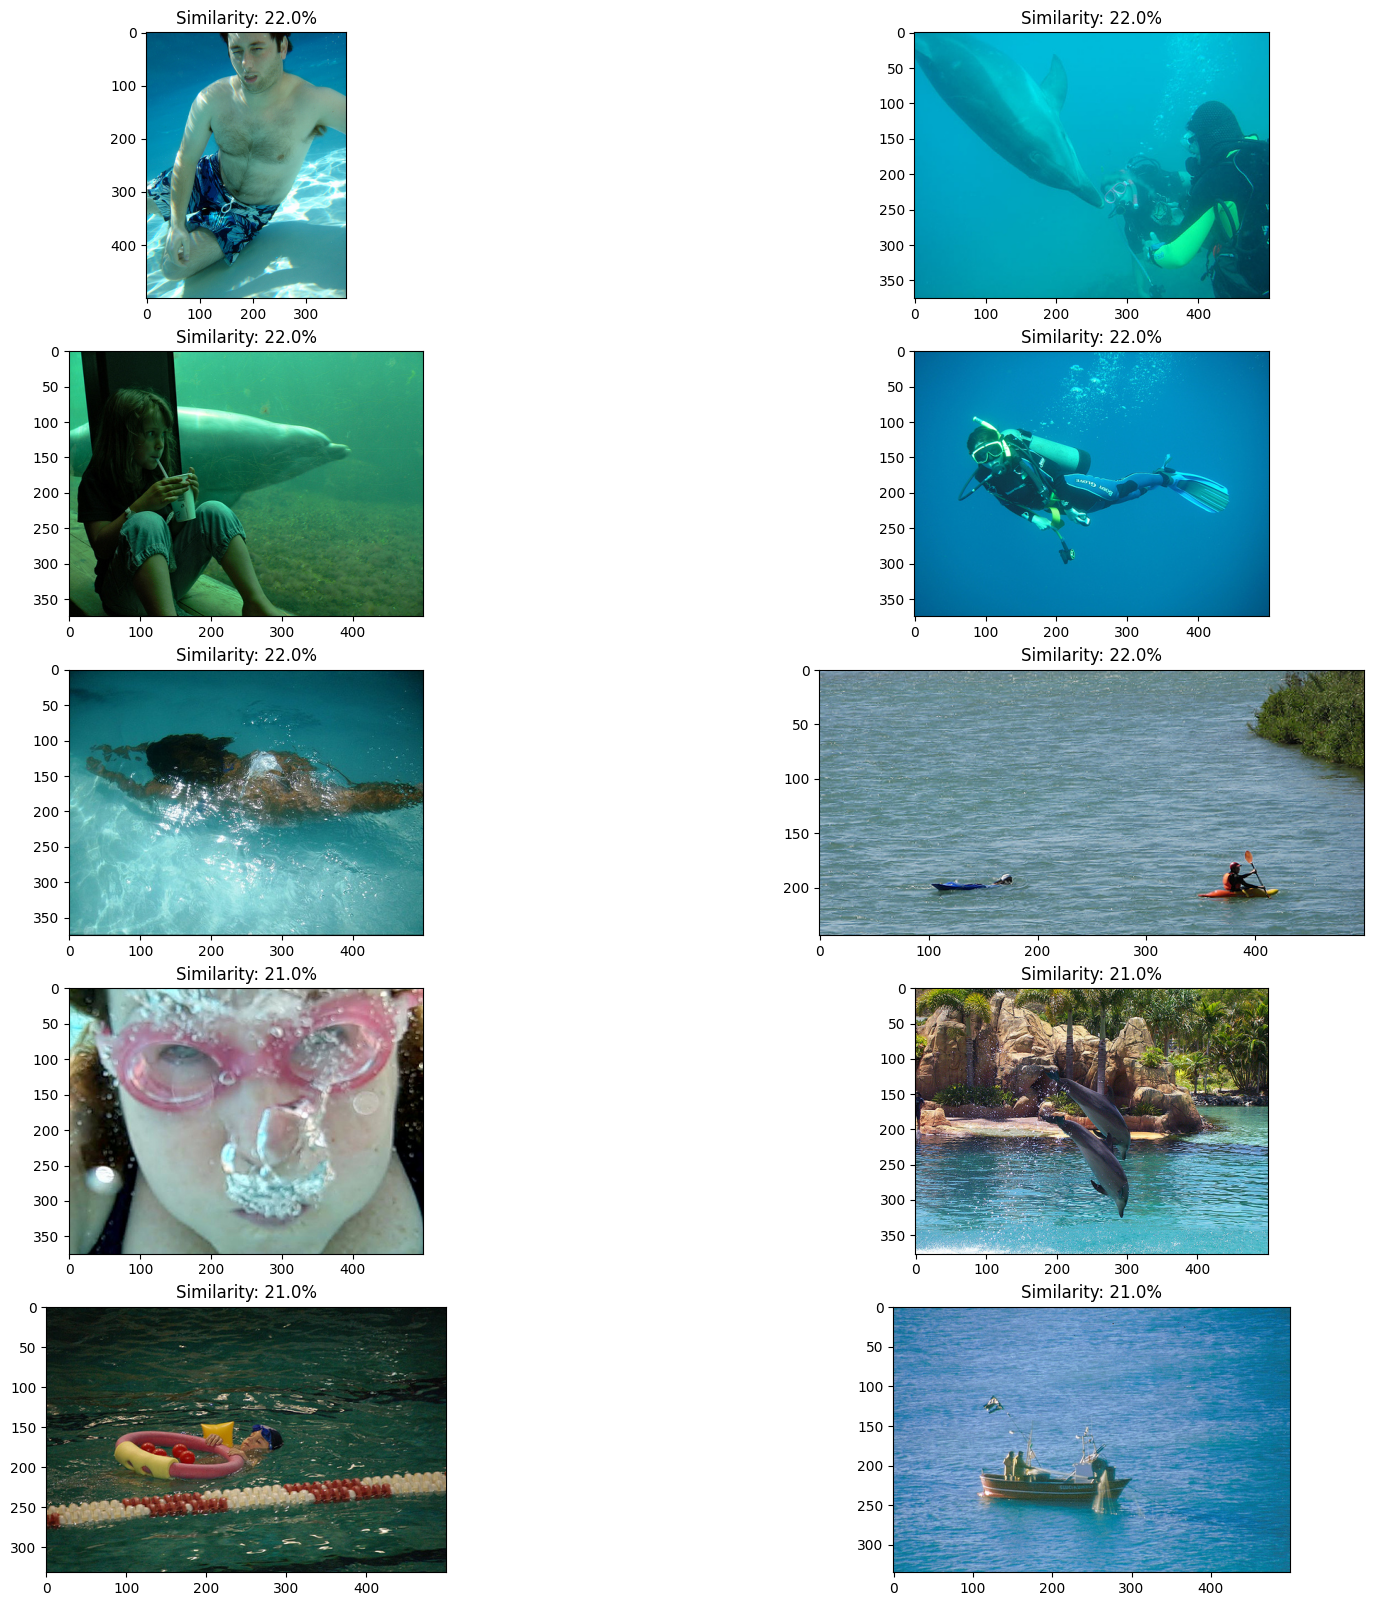

In [48]:
plot_images_by_side(top_images)

### a. Image to image search

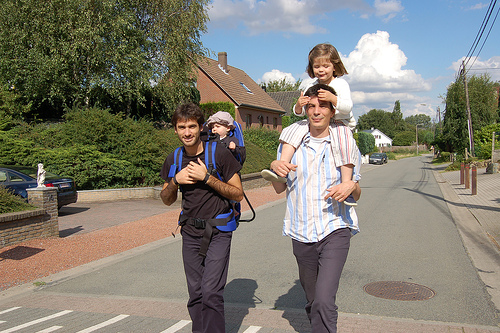

In [42]:
query_image = image_data_df.iloc[55].image
query_image

🌷: 5


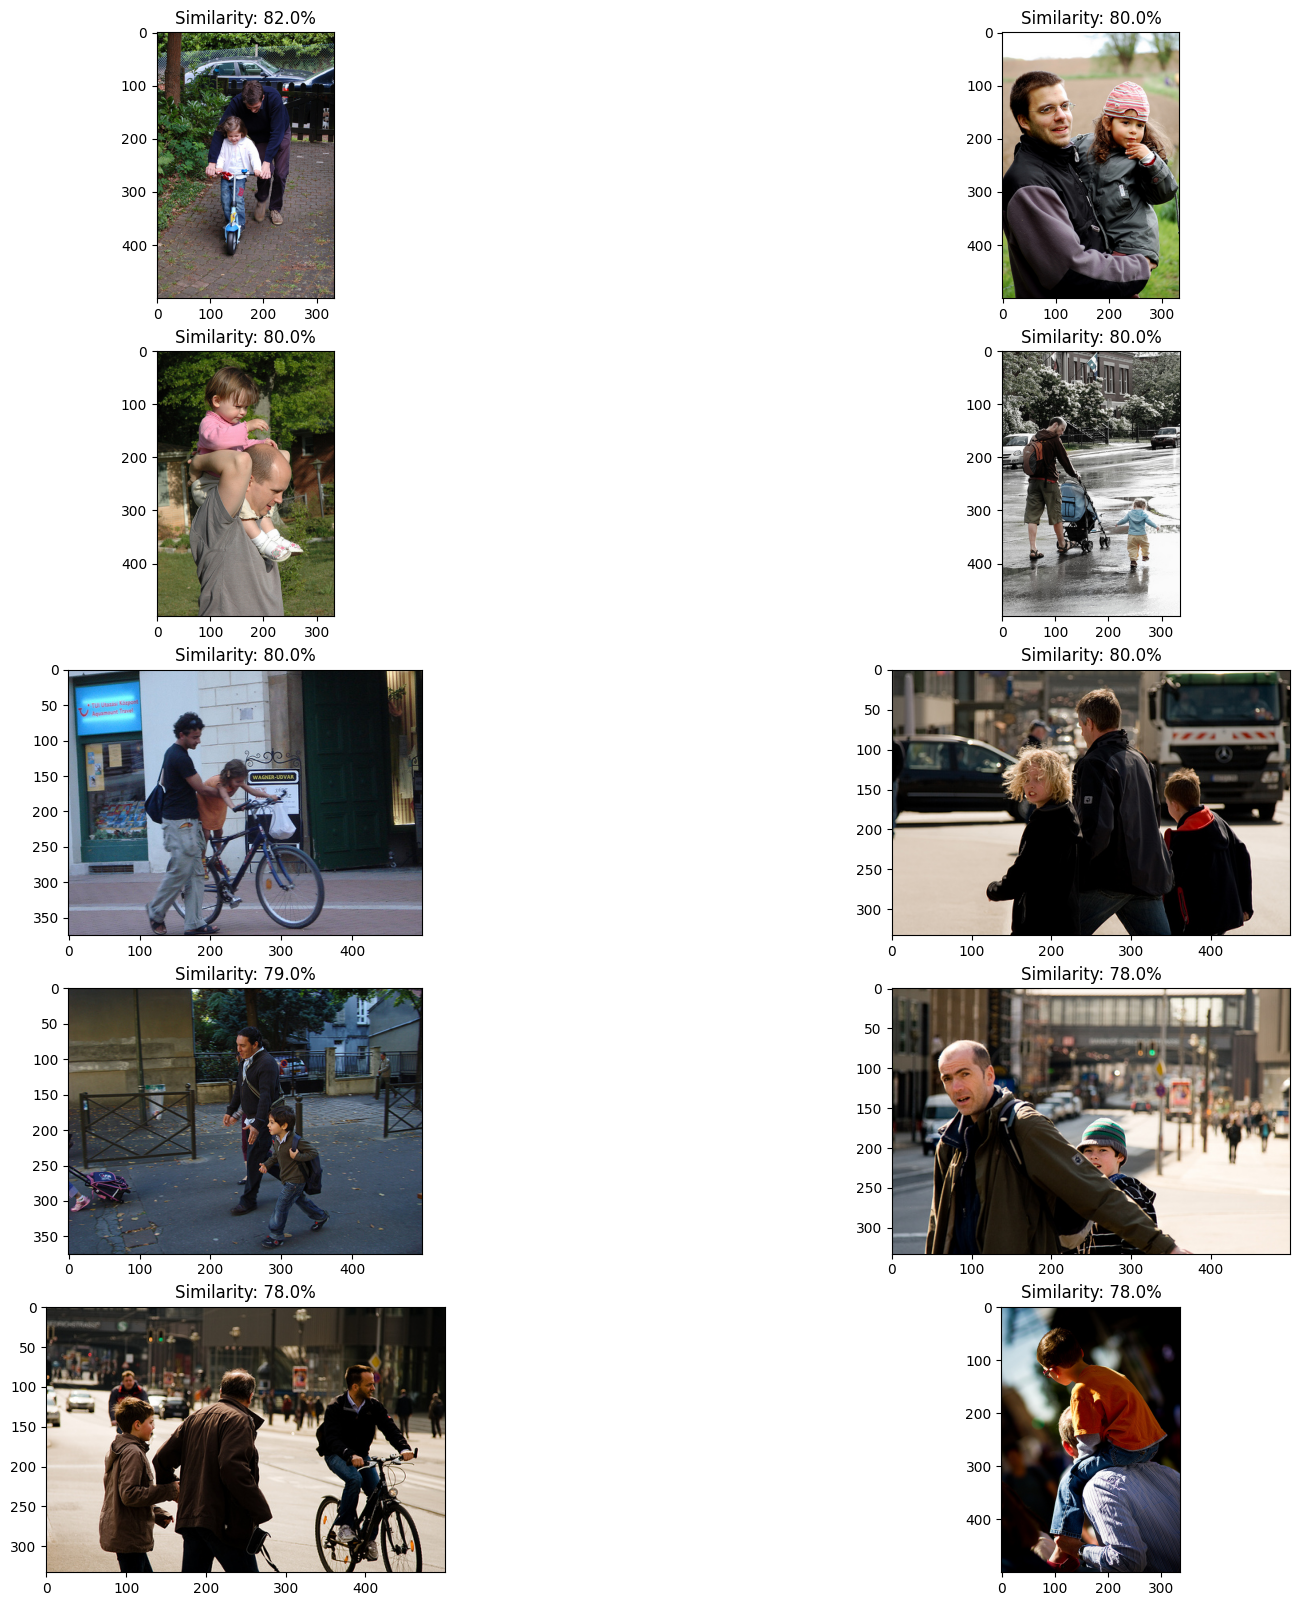

In [43]:
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
plot_images_by_side(top_images)

In [76]:
type(image_data_df.image_name.values)

numpy.ndarray

# Load label data

In [80]:
label_data_df = pd.read_csv('./label.csv')
label_data_df = label_data_df.fillna(method='ffill')
label_data_df.head(5)

C:\Users\phuon\AppData\Local\Temp\ipykernel_16780\3537277819.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  label_data_df = label_data_df.fillna(method='ffill')


text_comment      image_name
0              white bear  1362851262.jpg
1              white bear  2318659263.jpg
2  Bird and water surface  2696394827.jpg
3  Bird and water surface  2860667542.jpg
4  Bird and water surface   298920219.jpg

In [81]:
label_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_comment  508 non-null    object
 1   image_name    508 non-null    object
dtypes: object(2)
memory usage: 8.1+ KB


# Độ đánh giá

In [56]:
def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    return round(len(act_set & pred_set) / float(len(act_set)), 2)

In [64]:
actual = np.array(["4", "5", "7", "8", "10"])
predicted = np.array(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
for k in range(1, 11):
    print(f"Recall@{k} = {recall(actual, predicted, k)}")

Recall@1 = 0.0
Recall@2 = 0.0
Recall@3 = 0.0
Recall@4 = 0.2
Recall@5 = 0.4
Recall@6 = 0.4
Recall@7 = 0.6
Recall@8 = 0.8
Recall@9 = 0.8
Recall@10 = 1.0


In [58]:
def precision(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    return round(len(act_set & pred_set) / float(len(pred_set)), 2)

In [60]:
actual = np.array(["4", "5", "7", "8", "10"])
predicted = np.array(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
for k in range(1, 11):
    print(f"Precision@{k} = {precision(actual, predicted, k)}")

Precision@1 = 0.0
Precision@2 = 0.0
Precision@3 = 0.0
Precision@4 = 0.25
Precision@5 = 0.4
Precision@6 = 0.33
Precision@7 = 0.43
Precision@8 = 0.5
Precision@9 = 0.44
Precision@10 = 0.5


In [67]:
def f1_score(precision, recall):
    try:
        return round(2 * precision * recall / (precision + recall), 2)
    except:
        None

In [70]:
actual = np.array(["4", "5", "7", "8", "10"])
predicted = np.array(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
for k in range(1, 11):
    # print(f"Precision@{k} = {precision(actual, predicted, k)}")
    # print(f"Recall@{k} = {recall(actual, predicted, k)}")
    print(f"F1 score@{k} = {f1_score(precision(actual, predicted, k), recall(actual, predicted, k))}")

F1 score@1 = None
F1 score@2 = None
F1 score@3 = None
F1 score@4 = 0.22
F1 score@5 = 0.4
F1 score@6 = 0.36
F1 score@7 = 0.5
F1 score@8 = 0.62
F1 score@9 = 0.57
F1 score@10 = 0.67
